### <span style="color:#800000">Fast API</span>

### <span style="color:#FF00FF">Import libraries</span>

In [2]:
import pandas as pd
import numpy as np
import random
import pickle
import torch
import io

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model


from fastapi import FastAPI, Query
from typing import List
import uvicorn

import nest_asyncio
nest_asyncio.apply()

### <span style="color:#FF00FF">Load the QA dataset</span>

In [3]:
df = pd.read_csv("../data/question_answers_clean.csv")

### <span style="color:#FF00FF">TF-IDF Vectorizer</span>

In [4]:
text_data = df['roles'].unique()
# Create the tf-idf feature matrix
tfidf_vectorizer = TfidfVectorizer()
sparse_matrix = tfidf_vectorizer.fit_transform(text_data)
doc_term_matrix = sparse_matrix.toarray()

In [5]:
def get_questionsbytag(df,tags):
    roles = []
    try:
        for t in tags:
            tgt_transform = tfidf_vectorizer.transform([t]).toarray()
            tgt_cosine = cosine_similarity(doc_term_matrix,tgt_transform)
            arr = np.stack((text_data, tgt_cosine.flatten()), axis=1)

            res = arr[np.flip(np.argsort(arr[:,1]))][0]
            if res[1] > 0:
                roles.append(res[0]) 
    except:
            pass    
    result = df[df.roles.isin(roles)][["roles","questions","answers"]]
    result = result.groupby('roles').sample(n=3)
    result = [tuple(x) for x in result.to_numpy()]
    random.shuffle(result)
    return result

### <span style="color:#800000">Loading Pre-trained models and Releated objects</span>

### <span style="color:#FF00FF">SPACY Model</span>

In [6]:
SPACY_obj = pickle.load(open("../models/SPACY_objects.pkl", "rb" ))
SPACY_model = SPACY_obj.get("spacy_model")

### <span style="color:#FF00FF">BERT Model</span>

In [7]:
BERT_obj = pickle.load(open("../models/BERT_objects.pkl", "rb" ))
BERT_model = BERT_obj.get("bert_model")

In [8]:
torch.save(BERT_model,"../models/BERT_model.pt")

In [9]:
BERT_model_pt = torch.load("../models/BERT_model.pt")

### <span style="color:#FF00FF">LSTM Model</span>

In [10]:
LSTM_obj = pickle.load(open("../models/LSTM_objects.pkl", "rb" ))
LSTM_model = load_model("../models/LSTMmodel.h5")

lstm_word2idx = LSTM_obj.get("lstm_word2idx")
lstm_tag2idx = LSTM_obj.get("lstm_tag2idx")
lstm_tags = LSTM_obj.get("lstm_tags")
lstm_max_len = LSTM_obj.get("lstm_max_len")

### <span style="color:#800000">Visualizing Model performance</span>

In [11]:
metrics1 = pd.DataFrame(SPACY_obj.get("spacy_metrics"),index = ['percentage']).T
metrics2 = pd.DataFrame(BERT_obj.get("bert_metrics"),index = ['percentage']).T
metrics3 = pd.DataFrame(LSTM_obj.get("lstm_metrics"),index = ['percentage']).T


model_perform = pd.concat([metrics1, metrics2,metrics3],keys=["SPACY", "BERT", "LSTM"]).reset_index()
model_perform = model_perform.rename(columns={'level_0': 'Models','level_1': 'Metrics'})
model_perform

,Models,Metrics,percentage
0,SPACY,F1-score,0.972449
1,SPACY,Accuracy,0.946997
2,SPACY,Precision,0.999306
3,SPACY,Recall,0.946997
4,BERT,F1-score,0.523777
5,BERT,Accuracy,0.911538
6,BERT,Precision,0.502935
7,BERT,Recall,0.546421
8,LSTM,F1-score,0.706675
9,LSTM,Accuracy,0.988805


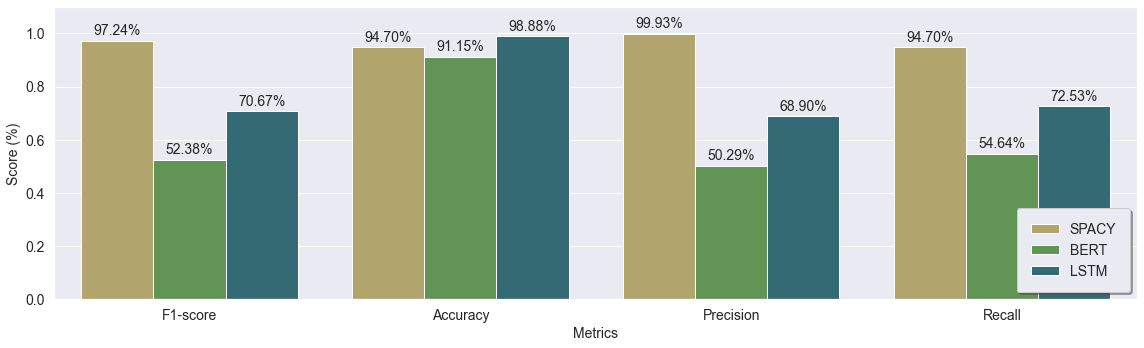

In [12]:
sns.set(style='darkgrid')
f, ax = plt.subplots(figsize =(16, 5)) 
splot = sns.barplot(x='Metrics', y="percentage", hue='Models', data=model_perform, ax=ax, 
                    palette = "gist_earth_r")


for p in splot.patches:
    splot.annotate("{0:.2f}%".format(p.get_height()*100), (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points',
                   fontsize=14)
    
    
# Create plot
plt.xlabel("Metrics", fontsize=14) 
plt.ylabel("Score (%)", fontsize=14)
plt.tight_layout()
plt.tick_params(labelsize=14)
plt.ylim(0.0, 1.1)
plt.legend(loc="lower right",framealpha=1,shadow=True, borderpad=1, fontsize=14)
plt.show()

In [13]:
def get_tags(model,text):
    res = []
    model = model.upper()
    if model == "SPACY":
        doc = SPACY_model(text)
        res = [(ent.text, ent.label_) for ent in doc.ents]
    
    if model == "LSTM":
        test_sentence = text.split()
        x_test_sent = pad_sequences(sequences=[[lstm_word2idx.get(w, 0) for w in test_sentence]],
                                    padding="post", value=lstm_tag2idx["O"], maxlen=lstm_max_len)

        p = LSTM_model.predict(np.array([x_test_sent[0]]))
        p = np.argmax(p, axis=-1)
        for w, pred in zip(test_sentence, p[0]):
            t = lstm_tags[pred]
            if t != "O":
                res.append((w, lstm_tags[pred]))
                
    if model == "BERT":
        prediction, model_output = BERT_model_pt.predict([text])
        d =  list(np.concatenate(prediction).flat)

        for k in d:
            for h,n in k.items():
                if n != "O":
                    res.append((h, n))

    
    res = { 'Entities' : set(res)}
    return res

### <span style="color:#FF00FF">Fast API endpoints</span>

In [ ]:
app = FastAPI()


@app.get('/')
def index():
    return "QA Model enpoint service"

@app.get('/metrics')
def metrics():
    return model_perform


@app.get('/tags')
def predict(model:str, jobdesc : str):
    res = get_tags(model,jobdesc)
    return res


@app.get('/questions')
def predict(data : List[str] = Query(None)):
    questions = get_questionsbytag(df,data)
    return { 'questions' : questions}

if __name__ == "__main__":
    uvicorn.run(app, host="127.0.0.1", port=8000)

INFO:     Started server process [3024]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:65060 - "GET /metrics HTTP/1.1" 200 OK


INFO:     127.0.0.1:65091 - "GET /metrics HTTP/1.1" 200 OK




INFO:     127.0.0.1:65095 - "GET /tags?model=BERT&jobdesc=description+scope+role+piramal+pharma+solutions+pps+chief+information+officer+cio+role+provide+vision+leadership+developing+implementing+information+technology+initiatives+align+vision+piramal+pharma+solutions+pps+businesses+pps+cio+charter+build+competitive+edge+business+proactively+building+world+class+high+quality+innovative+technology+digital+analytics+solutions+global+operations+job+overview+strategy+innovation+strategic+business+partner+create+enhanced+digital+technology+vision+enterprise+identify+opportunities+differentiated+technology+capabilities+solutions+p+roactively+recommend+solutions+business+functional+leadership+team+considering+business+vision+industry+trends+bringing+outside+perspective+p+ush+bar+technology+innovation+imbibing+cutting+edge+technological+innovations+global+benchmarks+blue+sky+thinking+create+user+friendly+technologies+offering+great+experience+cts+champion+change+agent+accelerating+organization

ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\uvicorn\protocols\http\h11_impl.py", line 396, in run_asgi
    result = await app(self.scope, self.receive, self.send)
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\uvicorn\middleware\proxy_headers.py", line 45, in __call__
    return await self.app(scope, receive, send)
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\fastapi\applications.py", line 199, in __call__
    await super().__call__(scope, receive, send)
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\starlette\applications.py", line 111, in __call__
    await self.middleware_stack(scope, receive, send)
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\starlette\middleware\errors.py", line 181, in __call__
    raise exc from None
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\starlette\middleware\errors.py", line 159

INFO:     127.0.0.1:65111 - "GET /tags?model=Spacy&jobdesc=description+scope+role+piramal+pharma+solutions+pps+chief+information+officer+cio+role+provide+vision+leadership+developing+implementing+information+technology+initiatives+align+vision+piramal+pharma+solutions+pps+businesses+pps+cio+charter+build+competitive+edge+business+proactively+building+world+class+high+quality+innovative+technology+digital+analytics+solutions+global+operations+job+overview+strategy+innovation+strategic+business+partner+create+enhanced+digital+technology+vision+enterprise+identify+opportunities+differentiated+technology+capabilities+solutions+p+roactively+recommend+solutions+business+functional+leadership+team+considering+business+vision+industry+trends+bringing+outside+perspective+p+ush+bar+technology+innovation+imbibing+cutting+edge+technological+innovations+global+benchmarks+blue+sky+thinking+create+user+friendly+technologies+offering+great+experience+cts+champion+change+agent+accelerating+organization

ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\uvicorn\protocols\http\h11_impl.py", line 396, in run_asgi
    result = await app(self.scope, self.receive, self.send)
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\uvicorn\middleware\proxy_headers.py", line 45, in __call__
    return await self.app(scope, receive, send)
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\fastapi\applications.py", line 199, in __call__
    await super().__call__(scope, receive, send)
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\starlette\applications.py", line 111, in __call__
    await self.middleware_stack(scope, receive, send)
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\starlette\middleware\errors.py", line 181, in __call__
    raise exc from None
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\starlette\middleware\errors.py", line 159

INFO:     127.0.0.1:65123 - "GET /tags?model=LSTM&jobdesc=description+scope+role+piramal+pharma+solutions+pps+chief+information+officer+cio+role+provide+vision+leadership+developing+implementing+information+technology+initiatives+align+vision+piramal+pharma+solutions+pps+businesses+pps+cio+charter+build+competitive+edge+business+proactively+building+world+class+high+quality+innovative+technology+digital+analytics+solutions+global+operations+job+overview+strategy+innovation+strategic+business+partner+create+enhanced+digital+technology+vision+enterprise+identify+opportunities+differentiated+technology+capabilities+solutions+p+roactively+recommend+solutions+business+functional+leadership+team+considering+business+vision+industry+trends+bringing+outside+perspective+p+ush+bar+technology+innovation+imbibing+cutting+edge+technological+innovations+global+benchmarks+blue+sky+thinking+create+user+friendly+technologies+offering+great+experience+cts+champion+change+agent+accelerating+organizationa

ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\uvicorn\protocols\http\h11_impl.py", line 396, in run_asgi
    result = await app(self.scope, self.receive, self.send)
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\uvicorn\middleware\proxy_headers.py", line 45, in __call__
    return await self.app(scope, receive, send)
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\fastapi\applications.py", line 199, in __call__
    await super().__call__(scope, receive, send)
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\starlette\applications.py", line 111, in __call__
    await self.middleware_stack(scope, receive, send)
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\starlette\middleware\errors.py", line 181, in __call__
    raise exc from None
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\starlette\middleware\errors.py", line 159

INFO:     127.0.0.1:65131 - "GET /tags?model=LSTM&jobdesc=description+scope+role+piramal+pharma+solutions+pps+chief+information+officer+cio+role+provide+vision+leadership+developing+implementing+information+technology+initiatives+align+vision+piramal+pharma+solutions+pps+businesses+pps+cio+charter+build+competitive+edge+business+proactively+building+world+class+high+quality+innovative+technology+digital+analytics+solutions+global+operations+job+overview+strategy+innovation+strategic+business+partner+create+enhanced+digital+technology+vision+enterprise+identify+opportunities+differentiated+technology+capabilities+solutions+p+roactively+recommend+solutions+business+functional+leadership+team+considering+business+vision+industry+trends+bringing+outside+perspective+p+ush+bar+technology+innovation+imbibing+cutting+edge+technological+innovations+global+benchmarks+blue+sky+thinking+create+user+friendly+technologies+offering+great+experience+cts+champion+change+agent+accelerating+organizationa

ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\uvicorn\protocols\http\h11_impl.py", line 396, in run_asgi
    result = await app(self.scope, self.receive, self.send)
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\uvicorn\middleware\proxy_headers.py", line 45, in __call__
    return await self.app(scope, receive, send)
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\fastapi\applications.py", line 199, in __call__
    await super().__call__(scope, receive, send)
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\starlette\applications.py", line 111, in __call__
    await self.middleware_stack(scope, receive, send)
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\starlette\middleware\errors.py", line 181, in __call__
    raise exc from None
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\starlette\middleware\errors.py", line 159

INFO:     127.0.0.1:65139 - "GET /tags?model=Spacy&jobdesc=description+scope+role+piramal+pharma+solutions+pps+chief+information+officer+cio+role+provide+vision+leadership+developing+implementing+information+technology+initiatives+align+vision+piramal+pharma+solutions+pps+businesses+pps+cio+charter+build+competitive+edge+business+proactively+building+world+class+high+quality+innovative+technology+digital+analytics+solutions+global+operations+job+overview+strategy+innovation+strategic+business+partner+create+enhanced+digital+technology+vision+enterprise+identify+opportunities+differentiated+technology+capabilities+solutions+p+roactively+recommend+solutions+business+functional+leadership+team+considering+business+vision+industry+trends+bringing+outside+perspective+p+ush+bar+technology+innovation+imbibing+cutting+edge+technological+innovations+global+benchmarks+blue+sky+thinking+create+user+friendly+technologies+offering+great+experience+cts+champion+change+agent+accelerating+organization


INFO:     127.0.0.1:65149 - "GET /metrics HTTP/1.1" 200 OK



INFO:     127.0.0.1:65152 - "GET /tags?model=BERT&jobdesc=description+scope+role+piramal+pharma+solutions+pps+chief+information+officer+cio+role+provide+vision+leadership+developing+implementing+information+technology+initiatives+align+vision+piramal+pharma+solutions+pps+businesses+pps+cio+charter+build+competitive+edge+business+proactively+building+world+class+high+quality+innovative+technology+digital+analytics+solutions+global+operations+job+overview+strategy+innovation+strategic+business+partner+create+enhanced+digital+technology+vision+enterprise+identify+opportunities+differentiated+technology+capabilities+solutions+p+roactively+recommend+solutions+business+functional+leadership+team+considering+business+vision+industry+trends+bringing+outside+perspective+p+ush+bar+technology+innovation+imbibing+cutting+edge+technological+innovations+global+benchmarks+blue+sky+thinking+create+user+friendly+technologies+offering+great+experience+cts+champion+change+agent+accelerating+organization


INFO:     127.0.0.1:65158 - "GET /tags?model=BERT&jobdesc=description+scope+role+piramal+pharma+solutions+pps+chief+information+officer+cio+role+provide+vision+leadership+developing+implementing+information+technology+initiatives+align+vision+piramal+pharma+solutions+pps+businesses+pps+cio+charter+build+competitive+edge+business+proactively+building+world+class+high+quality+innovative+technology+digital+analytics+solutions+global+operations+job+overview+strategy+innovation+strategic+business+partner+create+enhanced+digital+technology+vision+enterprise+identify+opportunities+differentiated+technology+capabilities+solutions+p+roactively+recommend+solutions+business+functional+leadership+team+considering+business+vision+industry+trends+bringing+outside+perspective+p+ush+bar+technology+innovation+imbibing+cutting+edge+technological+innovations+global+benchmarks+blue+sky+thinking+create+user+friendly+technologies+offering+great+experience+cts+champion+change+agent+accelerating+organization

ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\uvicorn\protocols\http\h11_impl.py", line 396, in run_asgi
    result = await app(self.scope, self.receive, self.send)
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\uvicorn\middleware\proxy_headers.py", line 45, in __call__
    return await self.app(scope, receive, send)
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\fastapi\applications.py", line 199, in __call__
    await super().__call__(scope, receive, send)
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\starlette\applications.py", line 111, in __call__
    await self.middleware_stack(scope, receive, send)
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\starlette\middleware\errors.py", line 181, in __call__
    raise exc from None
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\starlette\middleware\errors.py", line 159

INFO:     127.0.0.1:65223 - "GET /tags?model=Spacy&jobdesc=description+scope+role+piramal+pharma+solutions+pps+chief+information+officer+cio+role+provide+vision+leadership+developing+implementing+information+technology+initiatives+align+vision+piramal+pharma+solutions+pps+businesses+pps+cio+charter+build+competitive+edge+business+proactively+building+world+class+high+quality+innovative+technology+digital+analytics+solutions+global+operations+job+overview+strategy+innovation+strategic+business+partner+create+enhanced+digital+technology+vision+enterprise+identify+opportunities+differentiated+technology+capabilities+solutions+p+roactively+recommend+solutions+business+functional+leadership+team+considering+business+vision+industry+trends+bringing+outside+perspective+p+ush+bar+technology+innovation+imbibing+cutting+edge+technological+innovations+global+benchmarks+blue+sky+thinking+create+user+friendly+technologies+offering+great+experience+cts+champion+change+agent+accelerating+organization

INFO:     127.0.0.1:65234 - "GET /metrics HTTP/1.1" 200 OK



INFO:     127.0.0.1:65238 - "GET /tags?model=BERT&jobdesc=description+scope+role+piramal+pharma+solutions+pps+chief+information+officer+cio+role+provide+vision+leadership+developing+implementing+information+technology+initiatives+align+vision+piramal+pharma+solutions+pps+businesses+pps+cio+charter+build+competitive+edge+business+proactively+building+world+class+high+quality+innovative+technology+digital+analytics+solutions+global+operations+job+overview+strategy+innovation+strategic+business+partner+create+enhanced+digital+technology+vision+enterprise+identify+opportunities+differentiated+technology+capabilities+solutions+p+roactively+recommend+solutions+business+functional+leadership+team+considering+business+vision+industry+trends+bringing+outside+perspective+p+ush+bar+technology+innovation+imbibing+cutting+edge+technological+innovations+global+benchmarks+blue+sky+thinking+create+user+friendly+technologies+offering+great+experience+cts+champion+change+agent+accelerating+organization

INFO:     127.0.0.1:65299 - "GET /questions?data=project+management&data=application&data=information+systems&data=compliance&data=applications&data=senior+management&data=track+record&data=information+technology&data=testing&data=leadership&data=development&data=lead&data=budget&data=operations&data=ability+manage&data=analytics&data=bi&data=decision+making&data=developing&data=support&data=salesforce&data=sap&data=ai&data=deployment HTTP/1.1" 200 OK


INFO:     127.0.0.1:65317 - "GET /metrics HTTP/1.1" 200 OK




INFO:     127.0.0.1:65320 - "GET /metrics HTTP/1.1" 200 OK


INFO:     127.0.0.1:65351 - "GET /metrics HTTP/1.1" 200 OK




INFO:     127.0.0.1:65355 - "GET /tags?model=BERT&jobdesc=description+scope+role+piramal+pharma+solutions+pps+chief+information+officer+cio+role+provide+vision+leadership+developing+implementing+information+technology+initiatives+align+vision+piramal+pharma+solutions+pps+businesses+pps+cio+charter+build+competitive+edge+business+proactively+building+world+class+high+quality+innovative+technology+digital+analytics+solutions+global+operations+job+overview+strategy+innovation+strategic+business+partner+create+enhanced+digital+technology+vision+enterprise+identify+opportunities+differentiated+technology+capabilities+solutions+p+roactively+recommend+solutions+business+functional+leadership+team+considering+business+vision+industry+trends+bringing+outside+perspective+p+ush+bar+technology+innovation+imbibing+cutting+edge+technological+innovations+global+benchmarks+blue+sky+thinking+create+user+friendly+technologies+offering+great+experience+cts+champion+change+agent+accelerating+organization

ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\uvicorn\protocols\http\h11_impl.py", line 396, in run_asgi
    result = await app(self.scope, self.receive, self.send)
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\uvicorn\middleware\proxy_headers.py", line 45, in __call__
    return await self.app(scope, receive, send)
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\fastapi\applications.py", line 199, in __call__
    await super().__call__(scope, receive, send)
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\starlette\applications.py", line 111, in __call__
    await self.middleware_stack(scope, receive, send)
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\starlette\middleware\errors.py", line 181, in __call__
    raise exc from None
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\starlette\middleware\errors.py", line 159

INFO:     127.0.0.1:65449 - "GET /metrics HTTP/1.1" 200 OK
INFO:     127.0.0.1:65452 - "GET /tags?model=Spacy&jobdesc=description+scope+role+piramal+pharma+solutions+pps+chief+information+officer+cio+role+provide+vision+leadership+developing+implementing+information+technology+initiatives+align+vision+piramal+pharma+solutions+pps+businesses+pps+cio+charter+build+competitive+edge+business+proactively+building+world+class+high+quality+innovative+technology+digital+analytics+solutions+global+operations+job+overview+strategy+innovation+strategic+business+partner+create+enhanced+digital+technology+vision+enterprise+identify+opportunities+differentiated+technology+capabilities+solutions+p+roactively+recommend+solutions+business+functional+leadership+team+considering+business+vision+industry+trends+bringing+outside+perspective+p+ush+bar+technology+innovation+imbibing+cutting+edge+technological+innovations+global+benchmarks+blue+sky+thinking+create+user+friendly+technologies+offering+great+exp

ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\uvicorn\protocols\http\h11_impl.py", line 396, in run_asgi
    result = await app(self.scope, self.receive, self.send)
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\uvicorn\middleware\proxy_headers.py", line 45, in __call__
    return await self.app(scope, receive, send)
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\fastapi\applications.py", line 199, in __call__
    await super().__call__(scope, receive, send)
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\starlette\applications.py", line 111, in __call__
    await self.middleware_stack(scope, receive, send)
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\starlette\middleware\errors.py", line 181, in __call__
    raise exc from None
  File "C:\Users\nages\anaconda3\envs\tf_gpu\lib\site-packages\starlette\middleware\errors.py", line 159

INFO:     127.0.0.1:49833 - "GET /metrics HTTP/1.1" 200 OK
INFO:     127.0.0.1:49839 - "GET /metrics HTTP/1.1" 200 OK
INFO:     127.0.0.1:49842 - "GET /tags?model=Spacy&jobdesc=description+scope+role+piramal+pharma+solutions+pps+chief+information+officer+cio+role+provide+vision+leadership+developing+implementing+information+technology+initiatives+align+vision+piramal+pharma+solutions+pps+businesses+pps+cio+charter+build+competitive+edge+business+proactively+building+world+class+high+quality+innovative+technology+digital+analytics+solutions+global+operations+job+overview+strategy+innovation+strategic+business+partner+create+enhanced+digital+technology+vision+enterprise+identify+opportunities+differentiated+technology+capabilities+solutions+p+roactively+recommend+solutions+business+functional+leadership+team+considering+business+vision+industry+trends+bringing+outside+perspective+p+ush+bar+technology+innovation+imbibing+cutting+edge+technological+innovations+global+benchmarks+blue+sky+th

INFO:     127.0.0.1:49851 - "GET /metrics HTTP/1.1" 200 OK




INFO:     127.0.0.1:49859 - "GET /metrics HTTP/1.1" 200 OK



INFO:     127.0.0.1:49862 - "GET /tags?model=BERT&jobdesc=description+scope+role+piramal+pharma+solutions+pps+chief+information+officer+cio+role+provide+vision+leadership+developing+implementing+information+technology+initiatives+align+vision+piramal+pharma+solutions+pps+businesses+pps+cio+charter+build+competitive+edge+business+proactively+building+world+class+high+quality+innovative+technology+digital+analytics+solutions+global+operations+job+overview+strategy+innovation+strategic+business+partner+create+enhanced+digital+technology+vision+enterprise+identify+opportunities+differentiated+technology+capabilities+solutions+p+roactively+recommend+solutions+business+functional+leadership+team+considering+business+vision+industry+trends+bringing+outside+perspective+p+ush+bar+technology+innovation+imbibing+cutting+edge+technological+innovations+global+benchmarks+blue+sky+thinking+create+user+friendly+technologies+offering+great+experience+cts+champion+change+agent+accelerating+organization

INFO:     127.0.0.1:65227 - "GET /questions?data=project+management&data=application&data=information+systems&data=compliance&data=applications&data=senior+management&data=track+record&data=information+technology&data=testing&data=leadership&data=development&data=lead&data=budget&data=operations&data=ability+manage&data=analytics&data=bi&data=decision+making&data=developing&data=support&data=salesforce&data=sap&data=ai&data=deployment HTTP/1.1" 200 OK
INFO:     127.0.0.1:65229 - "GET /metrics HTTP/1.1" 200 OK
INFO:     127.0.0.1:65233 - "GET /tags?model=Spacy&jobdesc=machine+learning HTTP/1.1" 200 OK
INFO:     127.0.0.1:65234 - "GET /questions?data=machine+learning HTTP/1.1" 200 OK
INFO:     127.0.0.1:65243 - "GET /tags?model=Spacy&jobdesc=description+scope+role+piramal+pharma+solutions+pps+chief+information+officer+cio+role+provide+vision+leadership+developing+implementing+information+technology+initiatives+align+vision+piramal+pharma+solutions+pps+businesses+pps+cio+charter+build+com

INFO:     127.0.0.1:65312 - "GET /questions?data=project+management&data=application&data=information+systems&data=compliance&data=applications&data=senior+management&data=track+record&data=information+technology&data=testing&data=leadership&data=development&data=lead&data=budget&data=operations&data=ability+manage&data=analytics&data=bi&data=decision+making&data=developing&data=support&data=salesforce&data=sap&data=ai&data=deployment HTTP/1.1" 200 OK


INFO:     127.0.0.1:65319 - "GET /metrics HTTP/1.1" 200 OK
INFO:     127.0.0.1:65326 - "GET /metrics HTTP/1.1" 200 OK




INFO:     127.0.0.1:65329 - "GET /tags?model=BERT&jobdesc=description+scope+role+piramal+pharma+solutions+pps+chief+information+officer+cio+role+provide+vision+leadership+developing+implementing+information+technology+initiatives+align+vision+piramal+pharma+solutions+pps+businesses+pps+cio+charter+build+competitive+edge+business+proactively+building+world+class+high+quality+innovative+technology+digital+analytics+solutions+global+operations+job+overview+strategy+innovation+strategic+business+partner+create+enhanced+digital+technology+vision+enterprise+identify+opportunities+differentiated+technology+capabilities+solutions+p+roactively+recommend+solutions+business+functional+leadership+team+considering+business+vision+industry+trends+bringing+outside+perspective+p+ush+bar+technology+innovation+imbibing+cutting+edge+technological+innovations+global+benchmarks+blue+sky+thinking+create+user+friendly+technologies+offering+great+experience+cts+champion+change+agent+accelerating+organization

### <span style="color:#FF00FF">Model Testing</span>

In [ ]:
test = "basic qualification diploma experience 3 5 years job summary seeking experienced skilled information technology candidate join growing organization position responsible supporting network databases systems updating system hardware software troubleshooting system errors assisting team members supporting data security optimization extensive background technology computer science experience maintaining installing systems must responsibilities duties setting workstations computers necessary peripheral devices checking computer hardware hdd mouses keyboards etc ensure functionality installing configuring appropriate software functions according specifications organize schedule upgrades maintenance without deterring others completing work perform troubleshooting diagnose resolve problems repair replace parts debugging etc maintain records logs repairs fixes maintenance schedule identify computer network equipment shortages place orders checking computer hardware hdd mouses keyboards etc ensure functionality installing configuring appropriate software functions according specifications organize schedule upgrades maintenance without deterring others completing work perform troubleshooting diagnose resolve problems repair replace parts debugging etc maintain records logs repairs fixes maintenance schedule identify computer network equipment shortages place orders"
get_tags("LSTM",test)

In [ ]:
get_tags("SPACY",test)

In [ ]:
get_tags("BERT",test)